# HarvestStat Data Profiling - Cameroon

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32633' # Cameroon
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/CM_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read())) # Authentication will be removed in the future
parameters = {
    'format': 'json',
    'country':  'Cameroon',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, auth=auth, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 2008	 | CM2008A1 | 10	| CM2008A2	| 58	| nan	| 0	|
| 2018	 | CM2018A1 | 10	| CM2018A2	| 58	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
df = df.dropna(subset=['admin_2'])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([CM_Admin2_2008], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 17,867
Removed 1 "Missing Value" points
5,835/5,836 "Area Planted" points are retained.
6,214/6,214 "Quantity Produced" points are retained.
5,817/5,817 "Yield" points are retained.
Current data points: 17,866

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1998 - 2008
24 grain types are found: Bambara groundnut, Banana (unspecified), Beans (mixed), Cassava, Cooking Banana (unspecified), Cowpea (unspecified), Groundnuts (In Shell), Maize (Corn), Melon (unspecified), Millet, Okras (Fresh), Onions, Pam nut or kernal (unspecified), Pineapple (unspecified), Potato (Irish), Rice (Paddy), Sesame Seed, Soybean (unspecified), Squash and Melon seeds, Sweet Potatoes, Taro (move to 1594AA), Tomato, Watermelon, Yams
5 seasons are found: Annual (12-01), North 1st Season (11-01), North 2nd Season (12-01), 1st Season (10-01), 2nd Season (12-01)
1 crop production s

- Cameroon crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-cameroon.png?itok=FlNQVtNG" width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_cm_calendar.png" width=900>

- comparison of boundaries

<img src="../figures/CM_admin_shapes.png" width=900>

- In Cameroon, basd on the FEWS NET data, there was one time of change in administrative units: 2018

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 2008	 | CM2008A1 | 10	| CM2008A2	| 58	|
| 2018	 | CM2018A1 | 10	| CM2018A2	| 58	|

- Here, we use **`CM2008A2`** to represent all admin-level 2 crop data because although there  is 2018 file, it doesn't appear to be used (e.g. no corresponding FNIDs)
- At admin-level 2,three crops have five seasons`Annual`,`North 1st Season`,`North 2nd Season `,`1st Season` and  `2nd Season`.

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = CM_Admin2_2008.copy().to_crs('epsg:32633')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #
# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()

In [5]:
# Link admin boundaries ------------------------- #
link_2008, over_2008 = FDW_PD_CreateAdminLink(CM_Admin2_2008,CM_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)

# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)

# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_CM.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_CM.csv is saved.


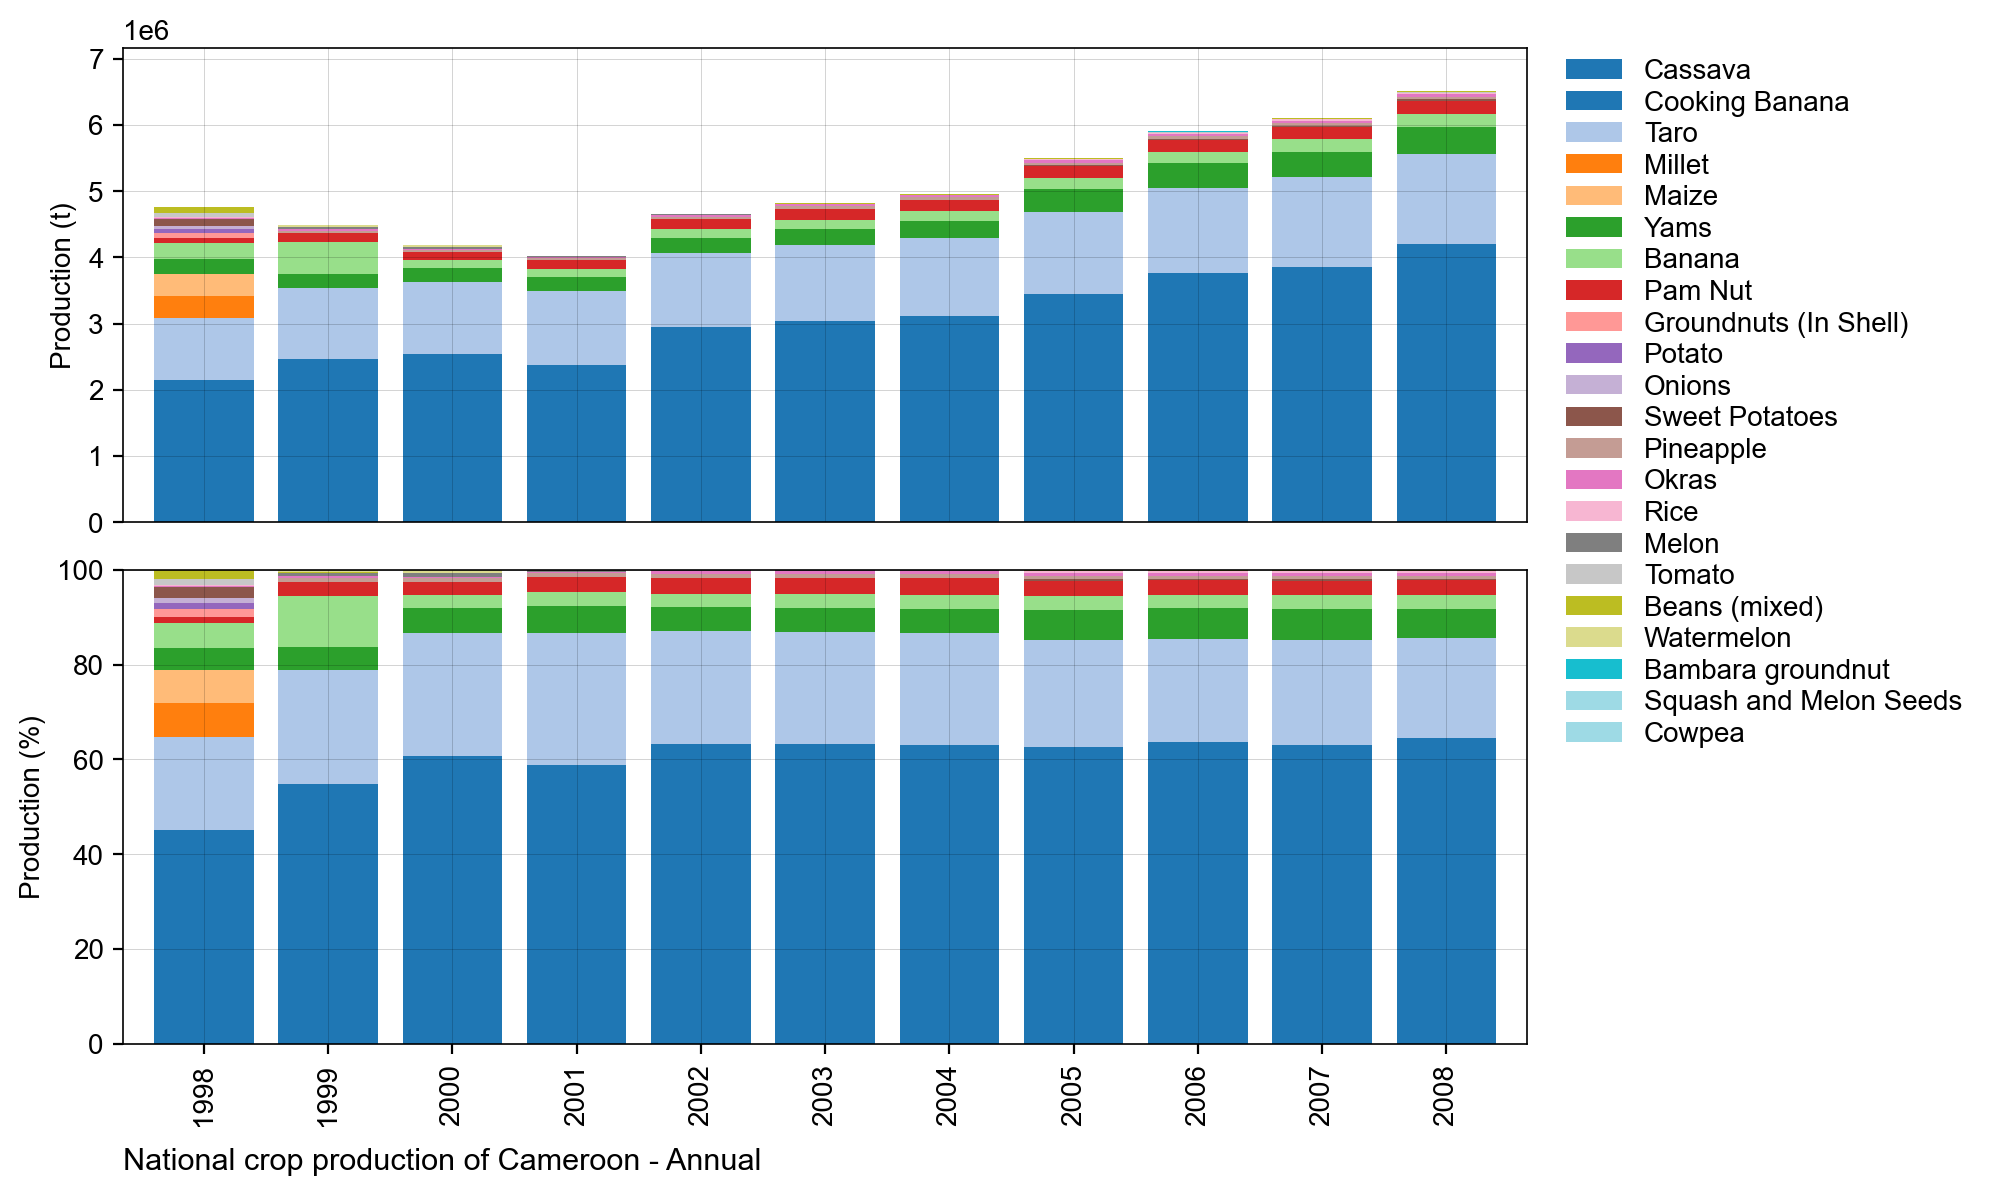

../figures/CM_bar_natgrainprod_Annual.png is saved.


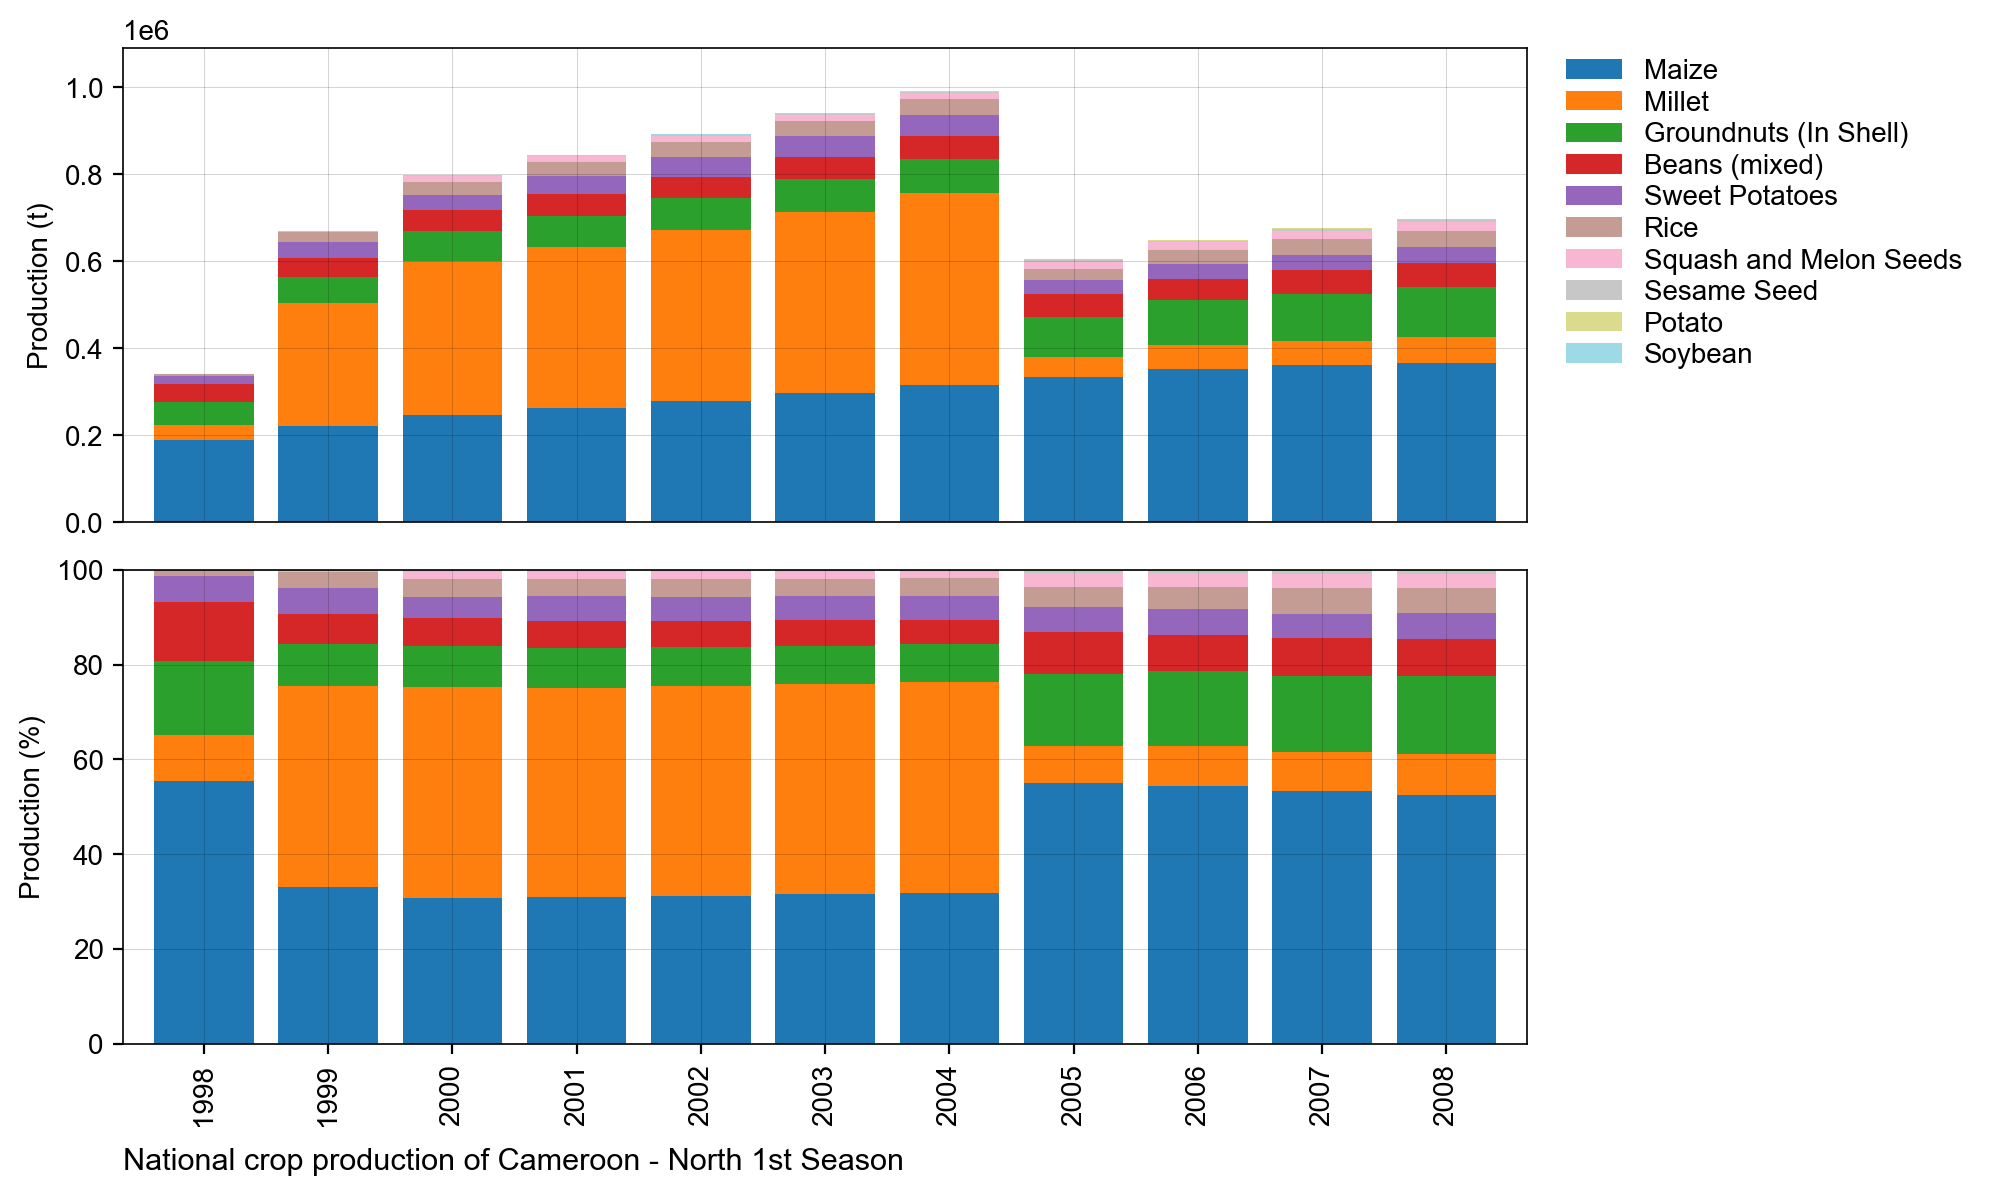

../figures/CM_bar_natgrainprod_North 1st Season.png is saved.


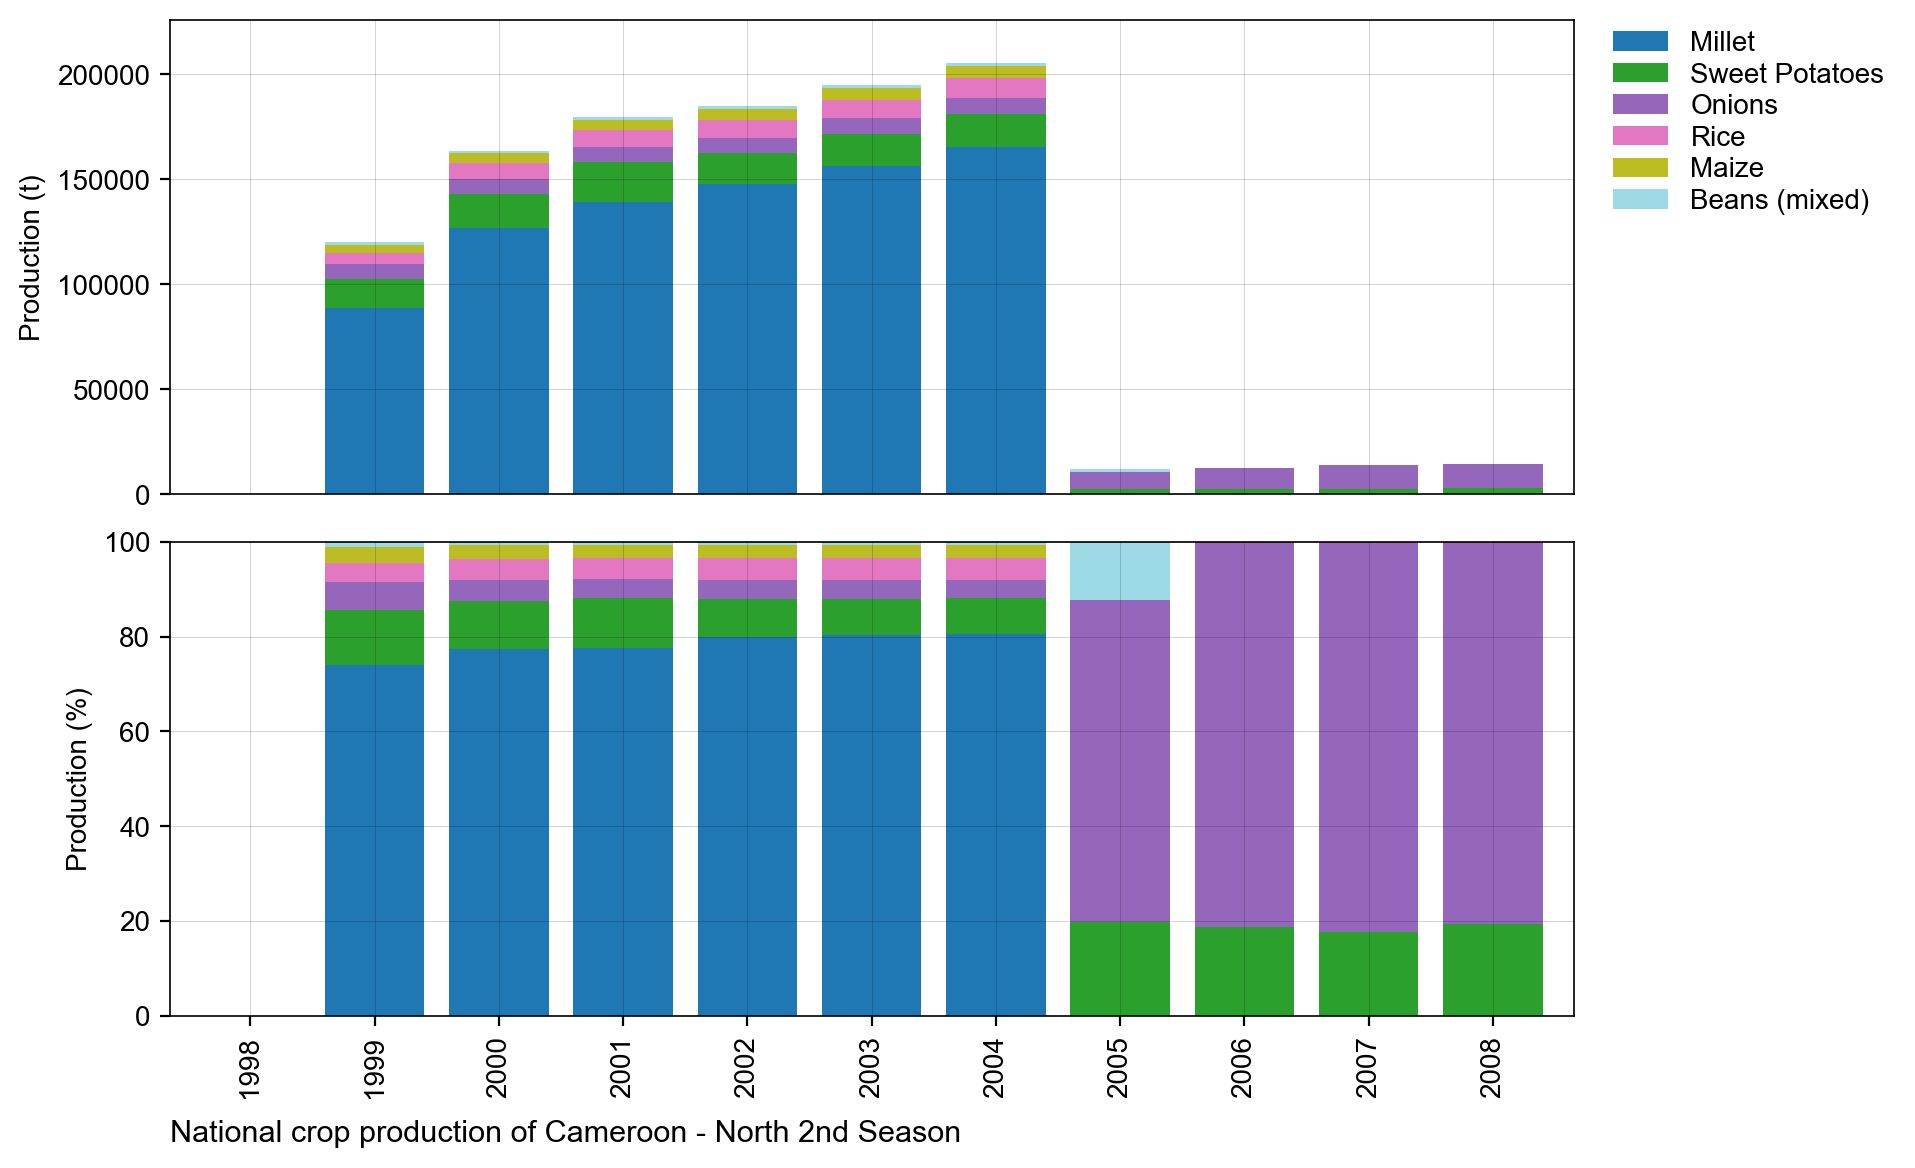

../figures/CM_bar_natgrainprod_North 2nd Season.png is saved.


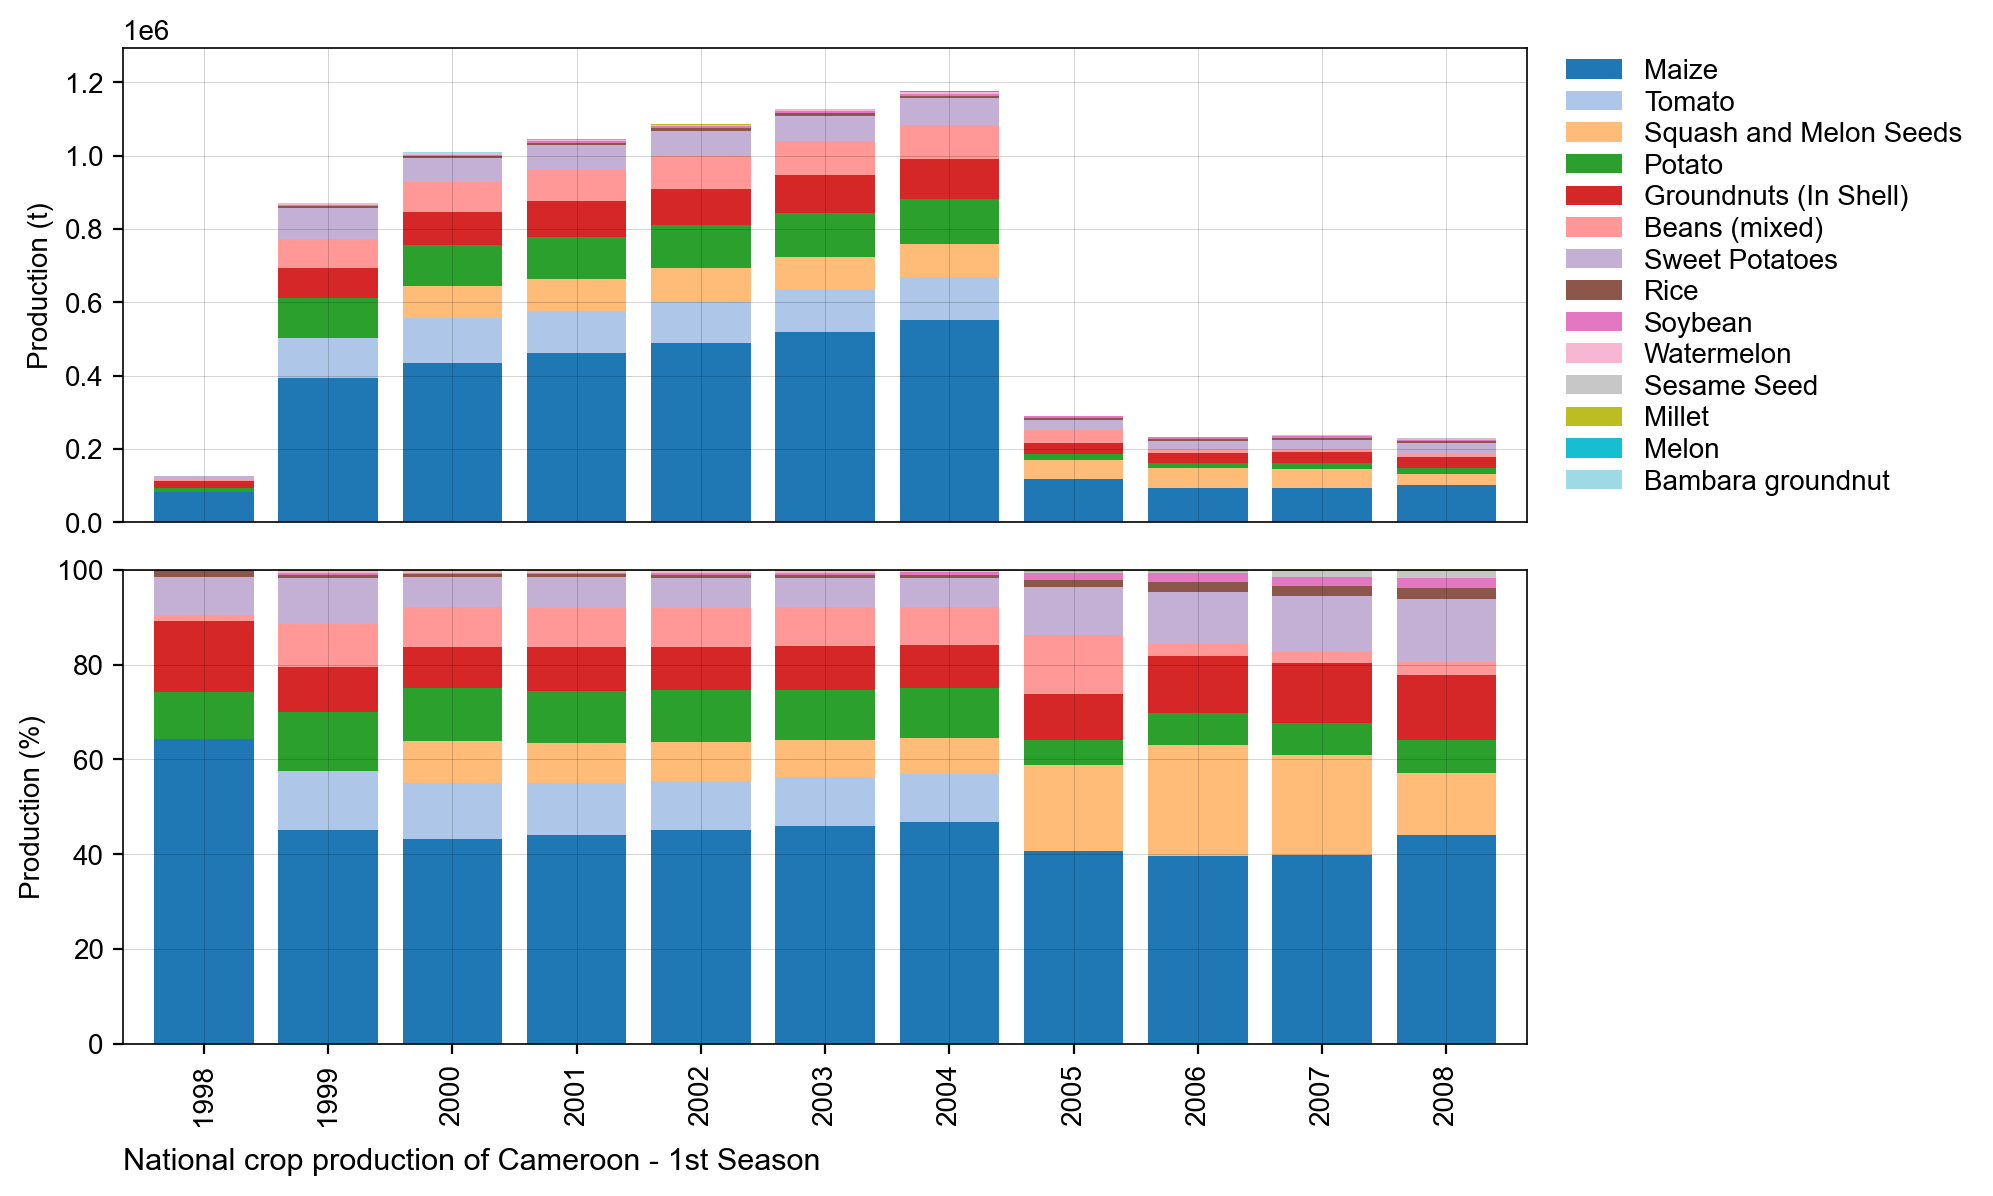

../figures/CM_bar_natgrainprod_1st Season.png is saved.


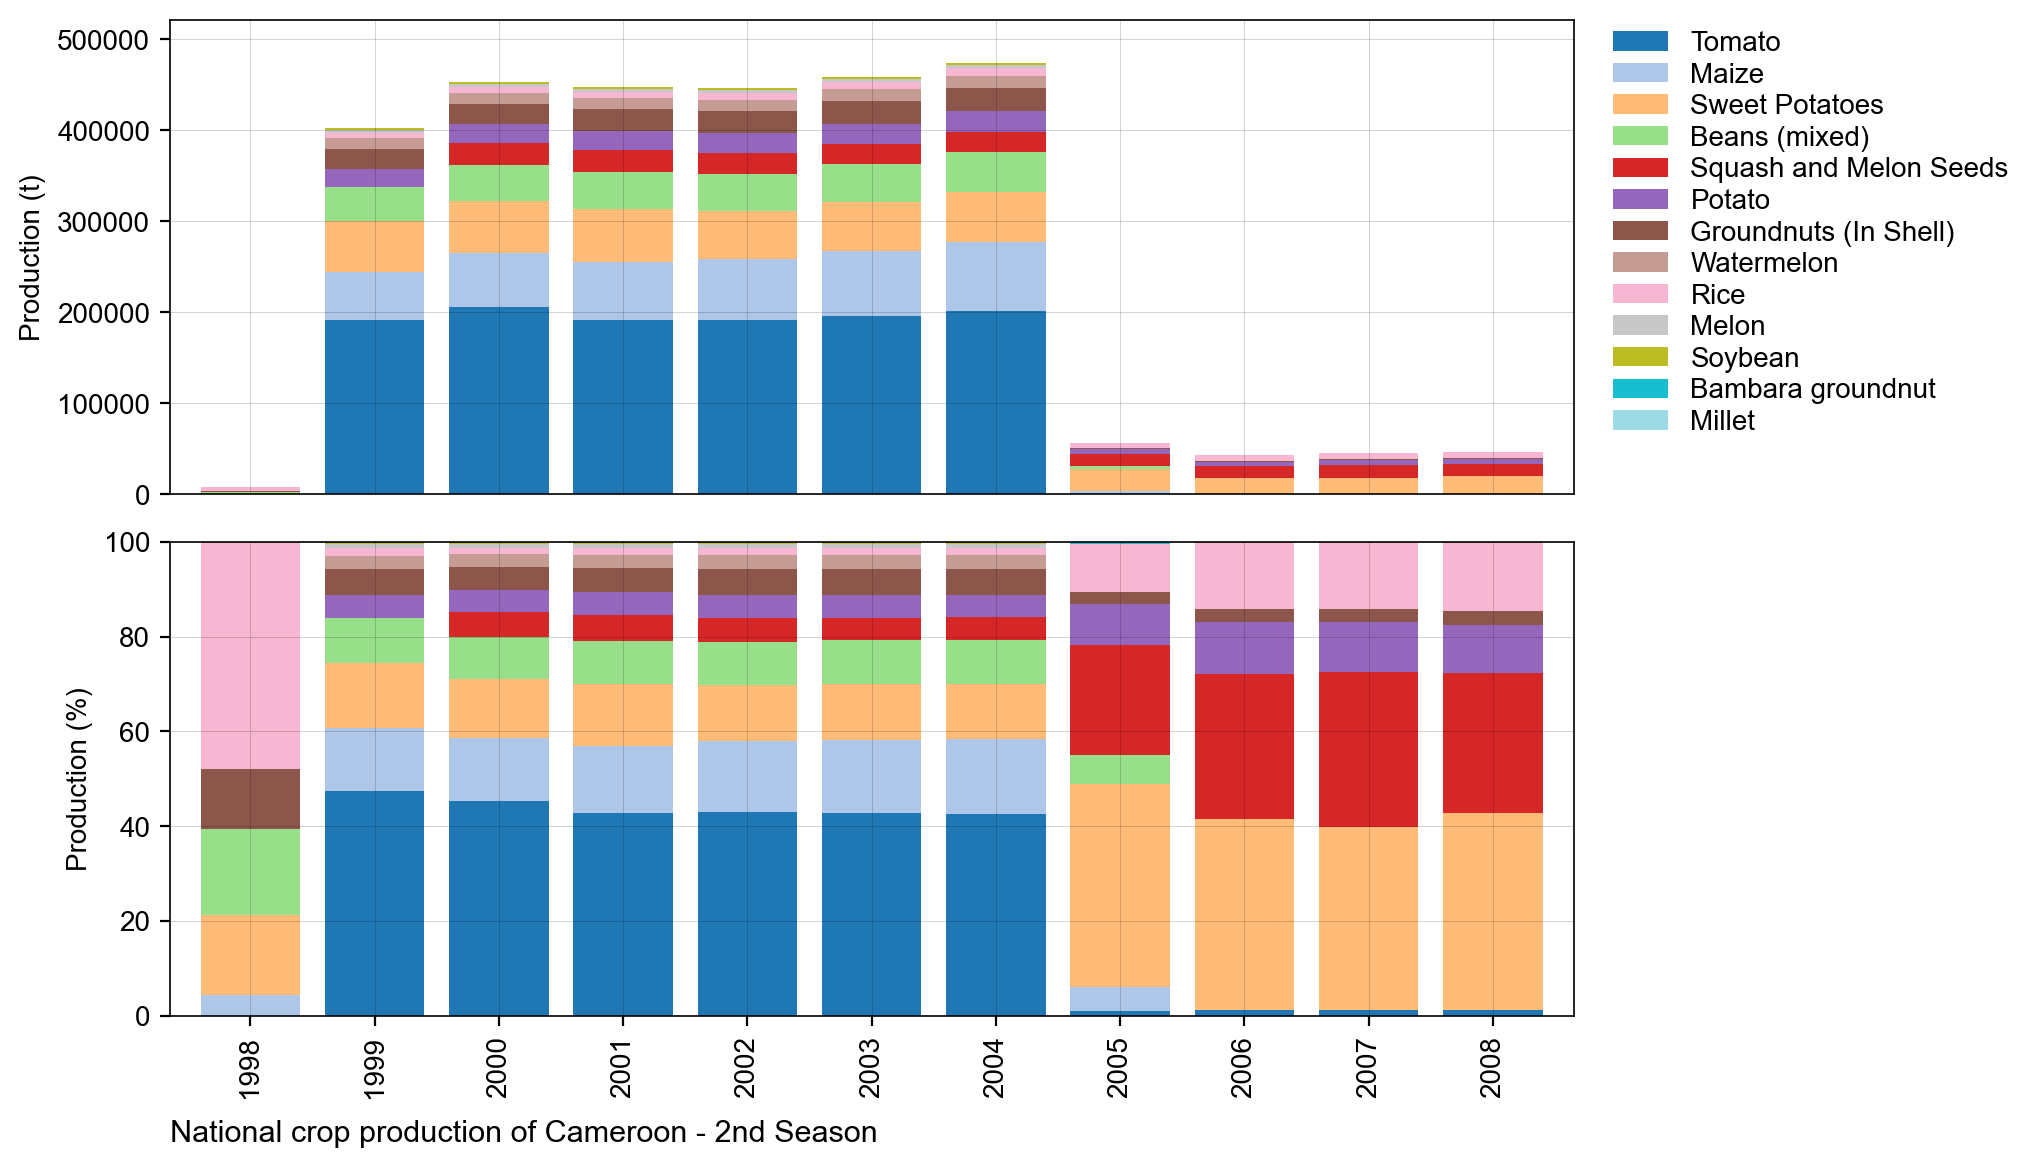

../figures/CM_bar_natgrainprod_2nd Season.png is saved.


In [7]:
# Bar chart of national crop production
country_iso, country_name = 'CM', 'Cameroon'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name   in ['Annual','North 1st Season','North 2nd Season','1st Season','2nd Season']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

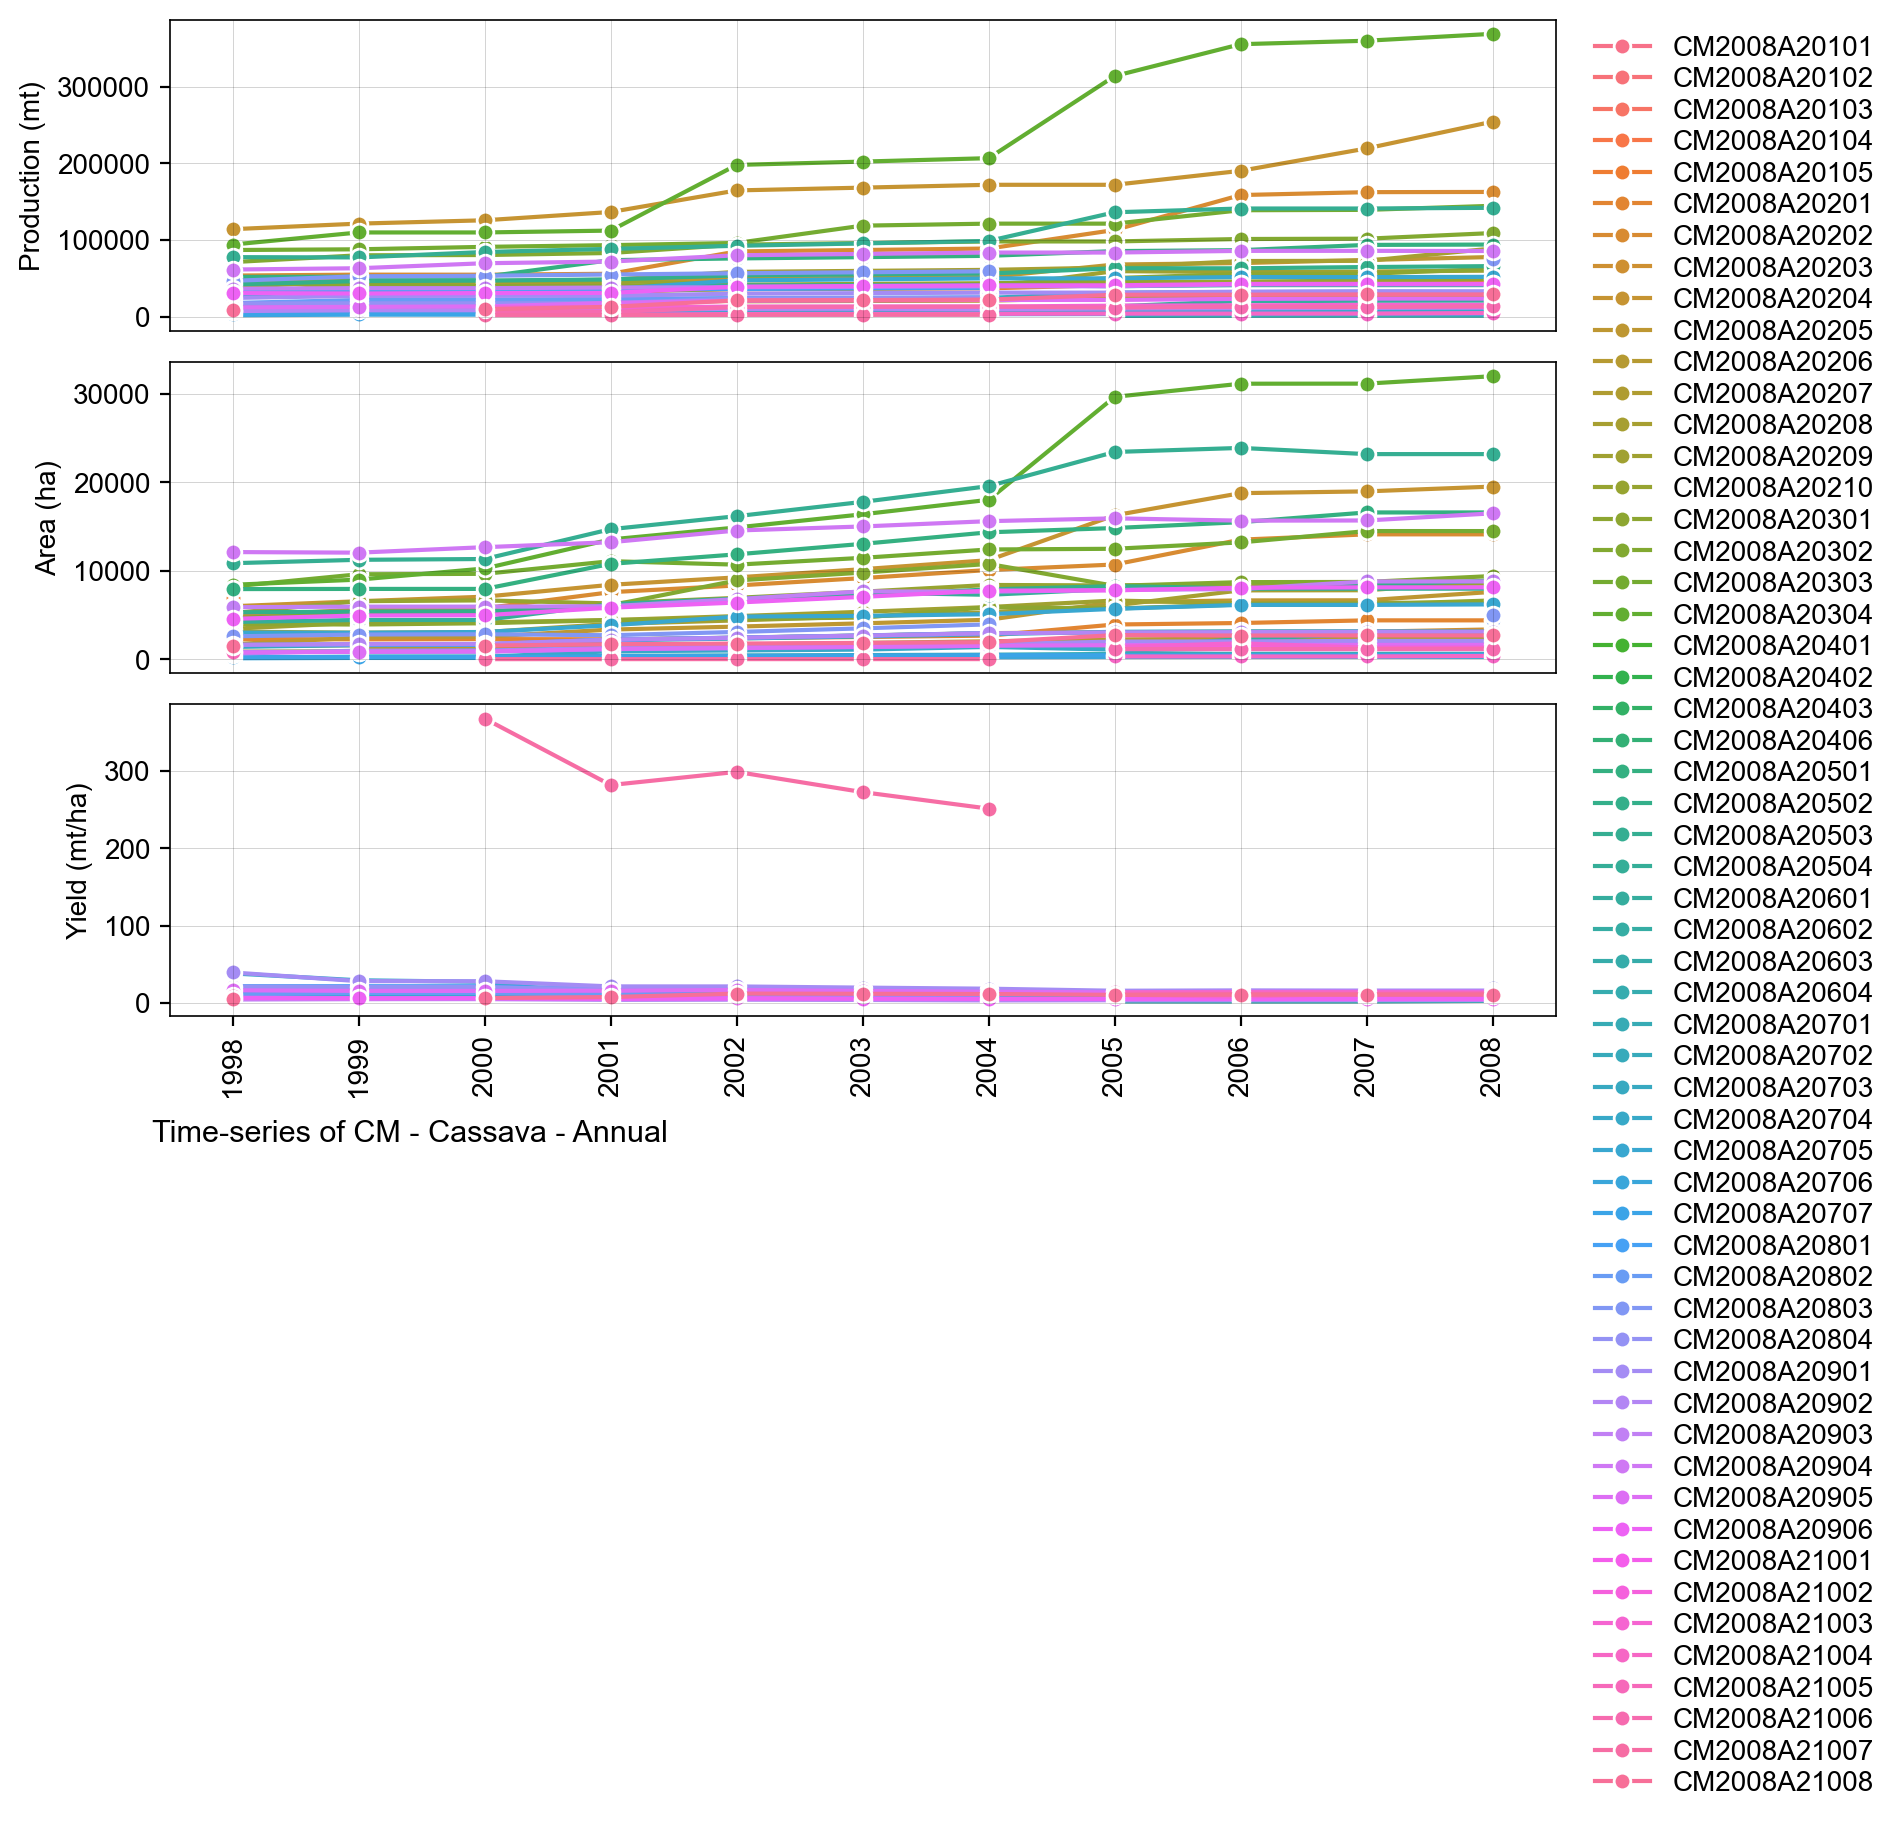

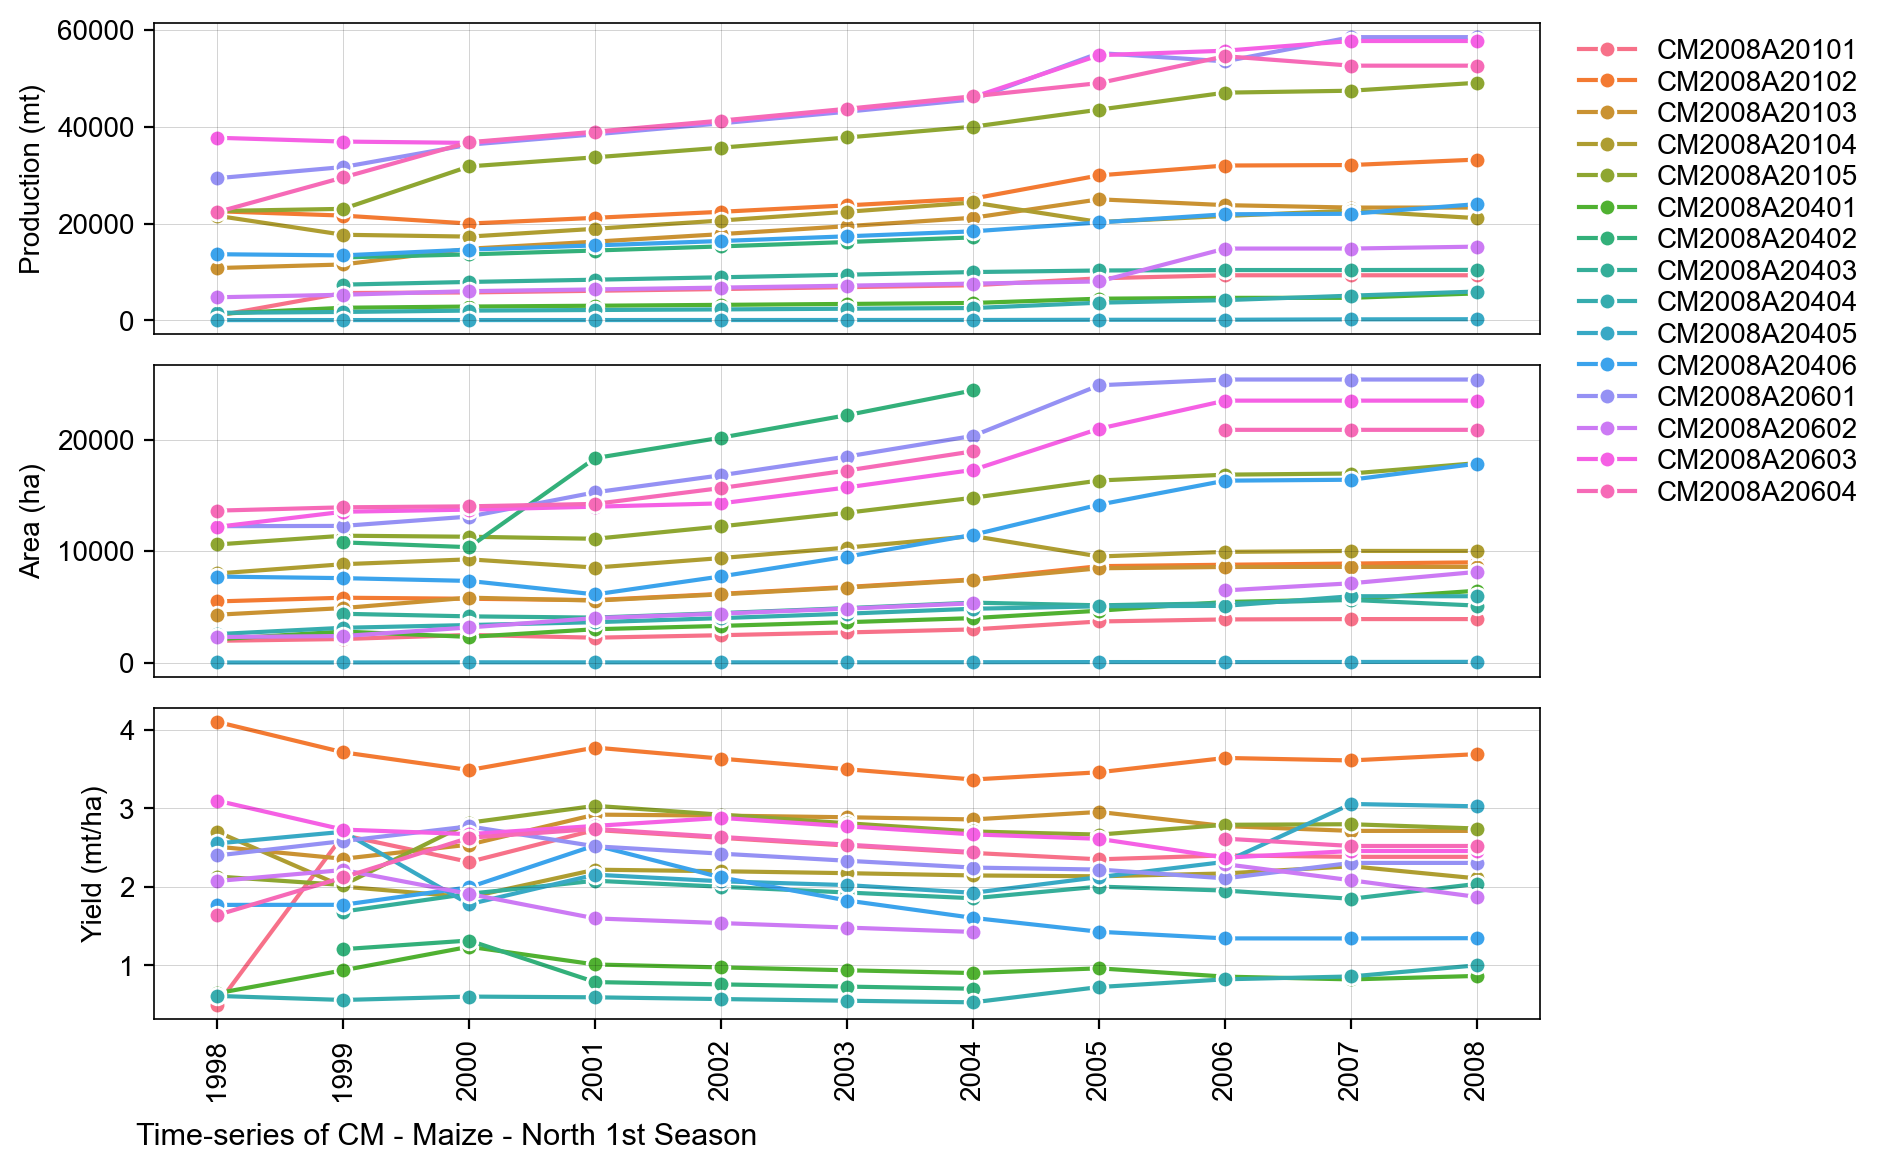

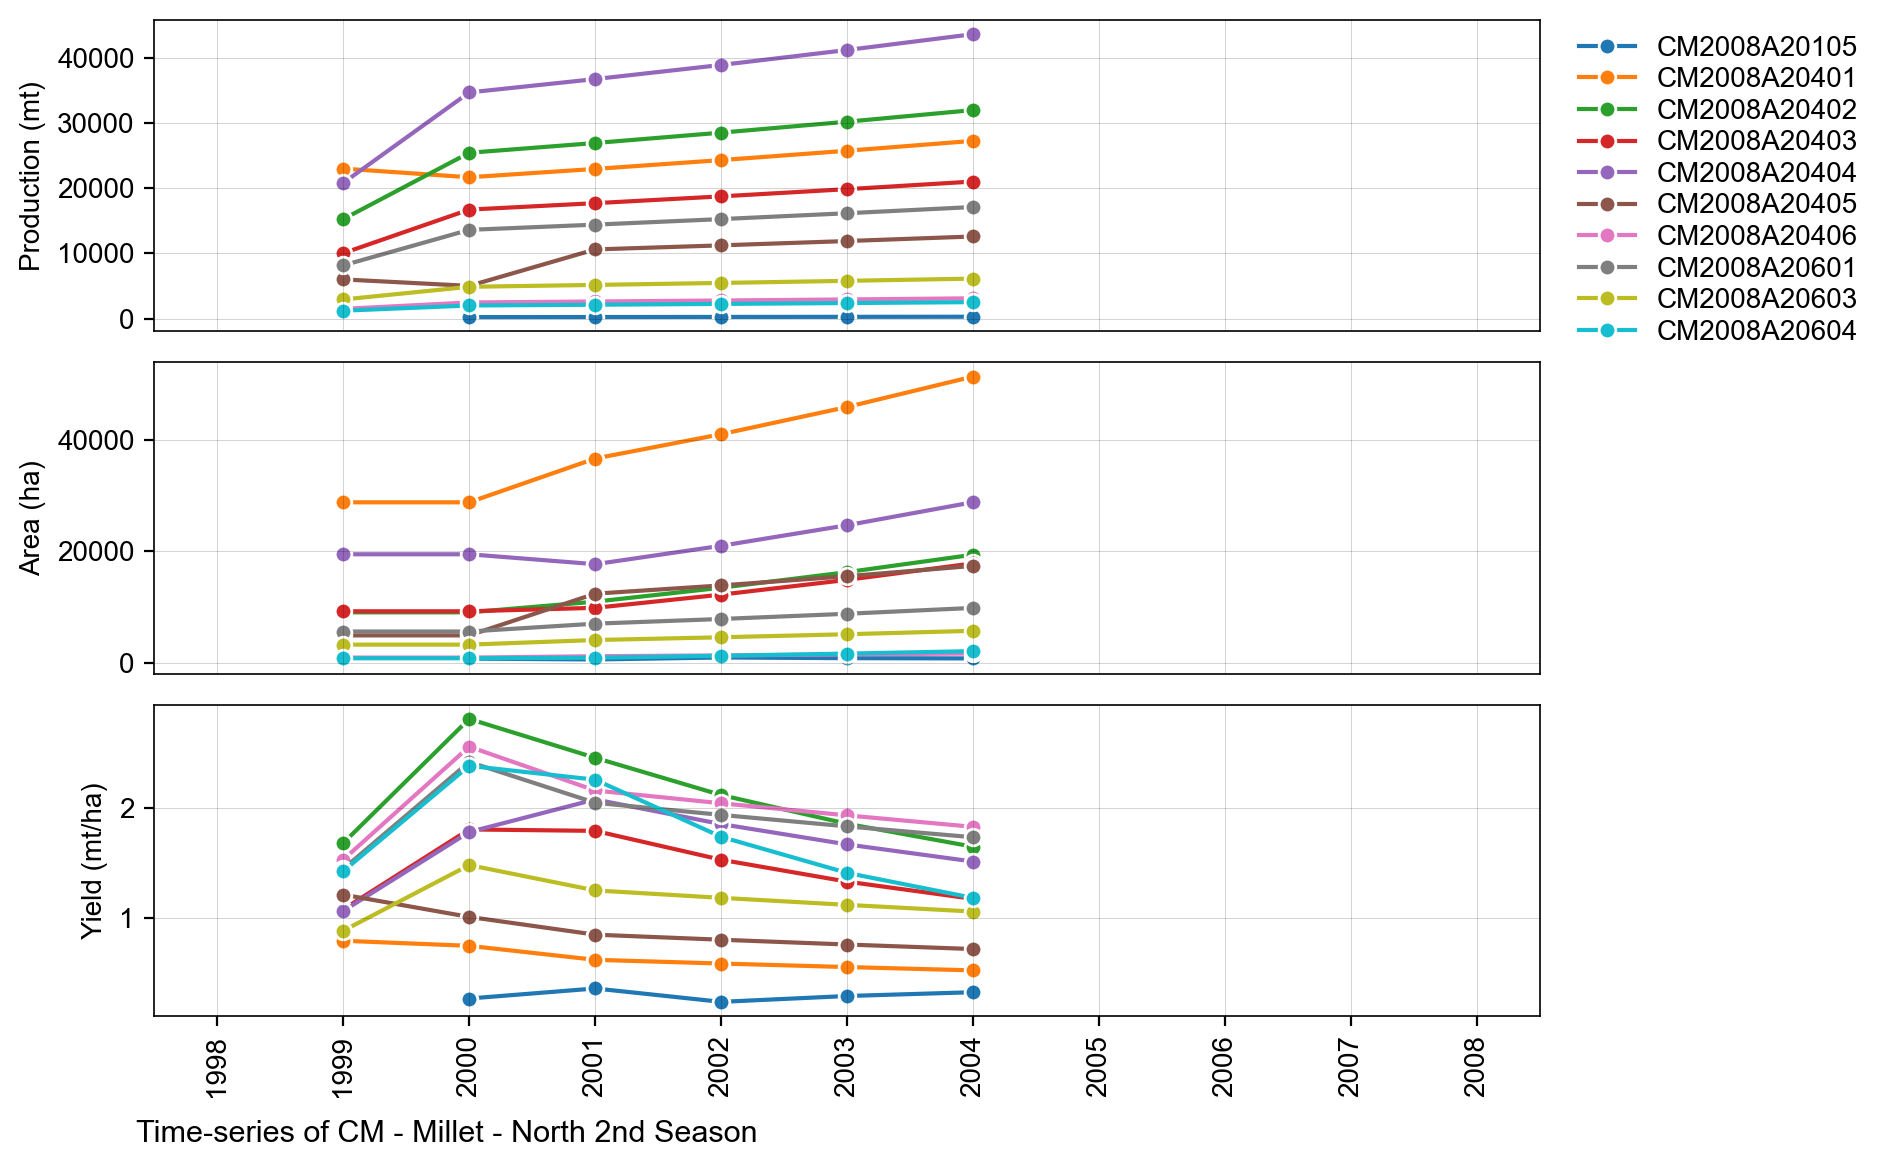

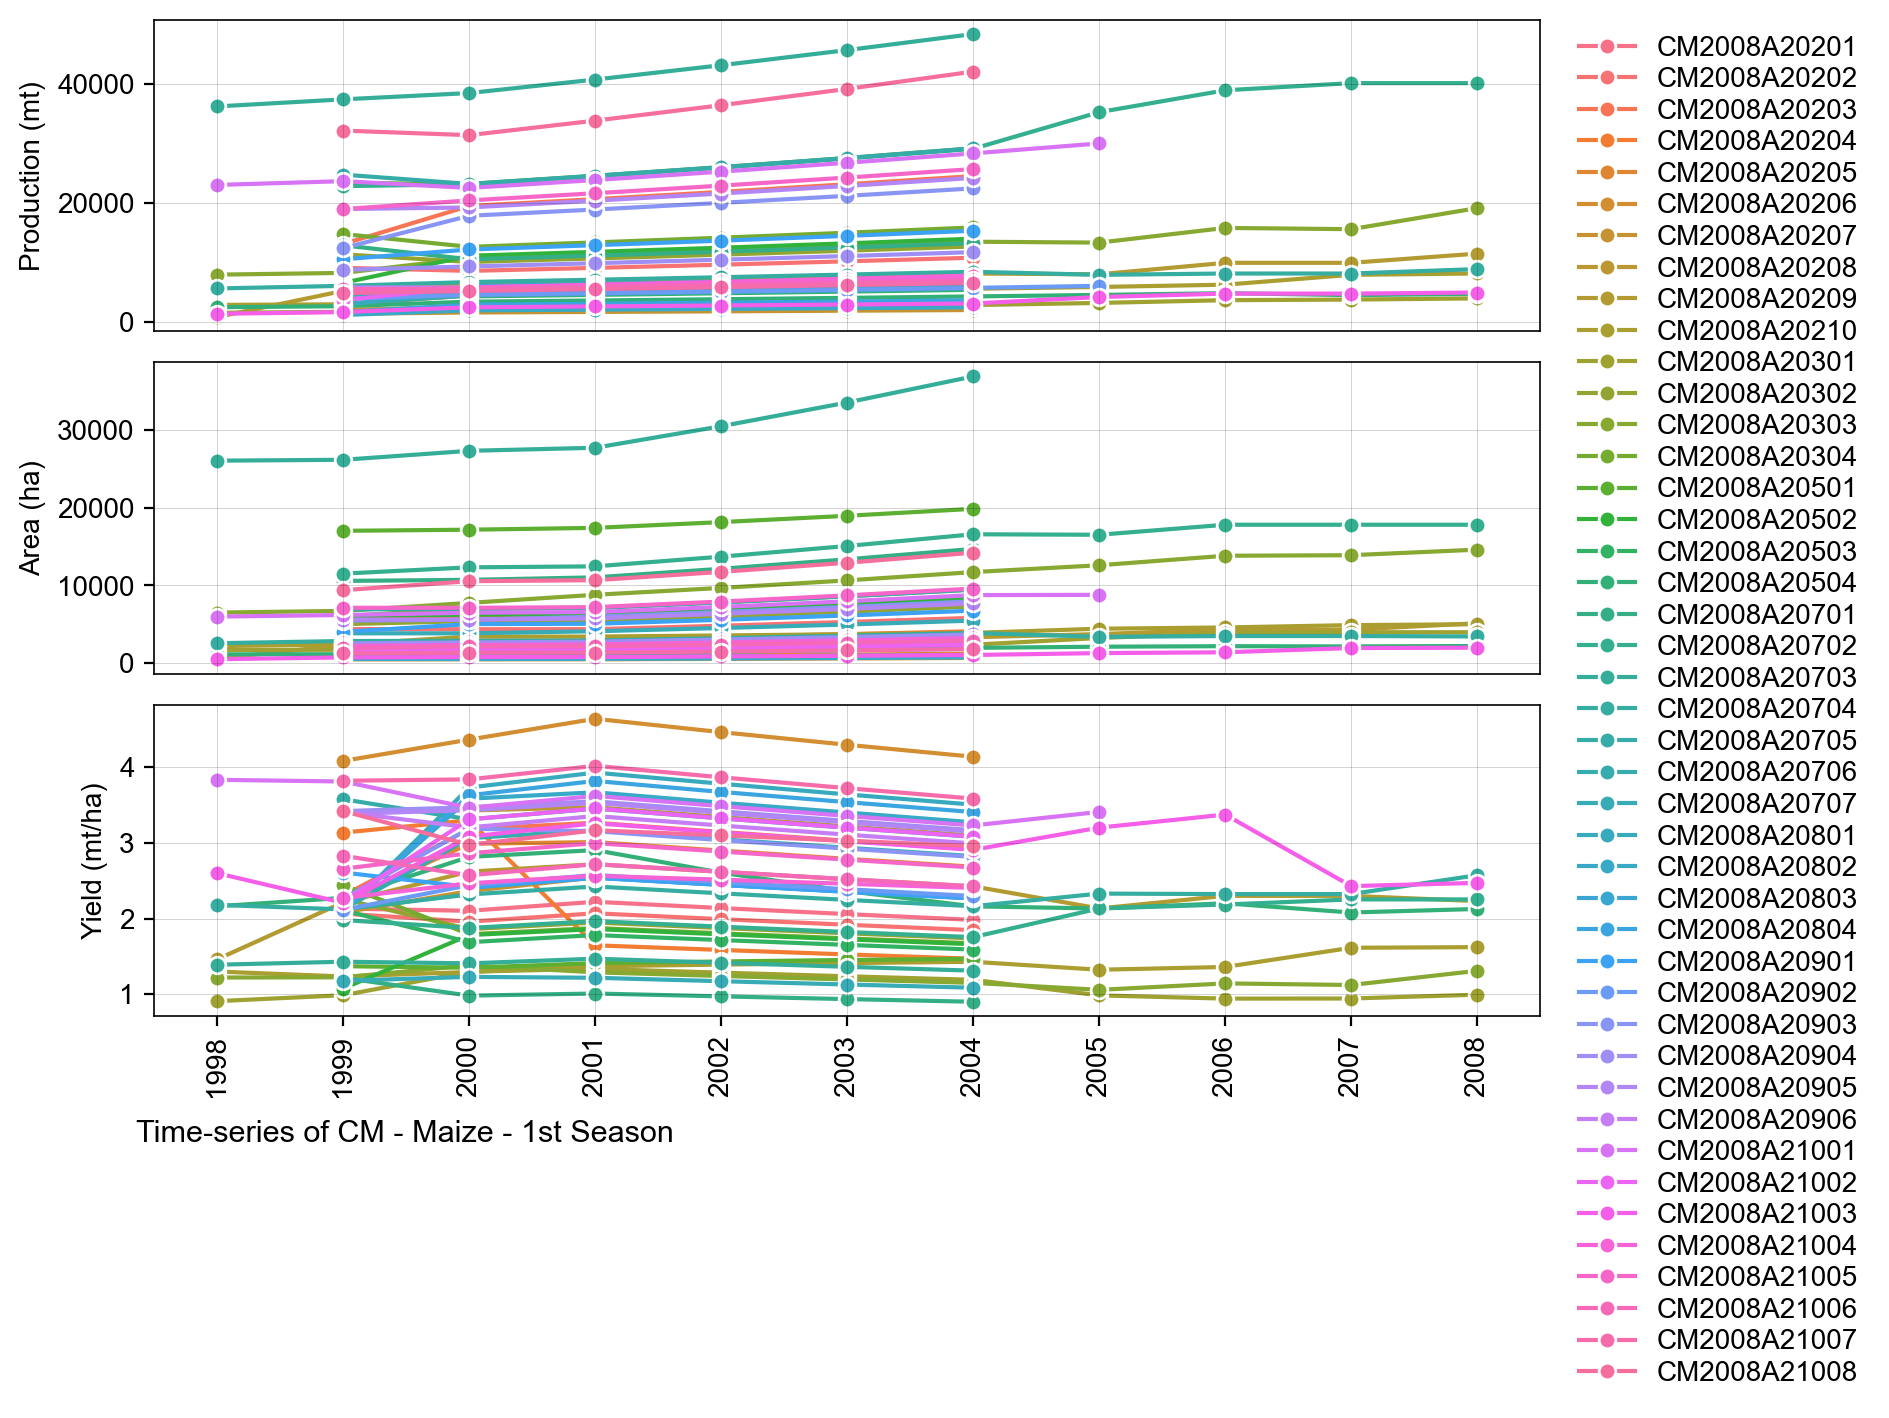

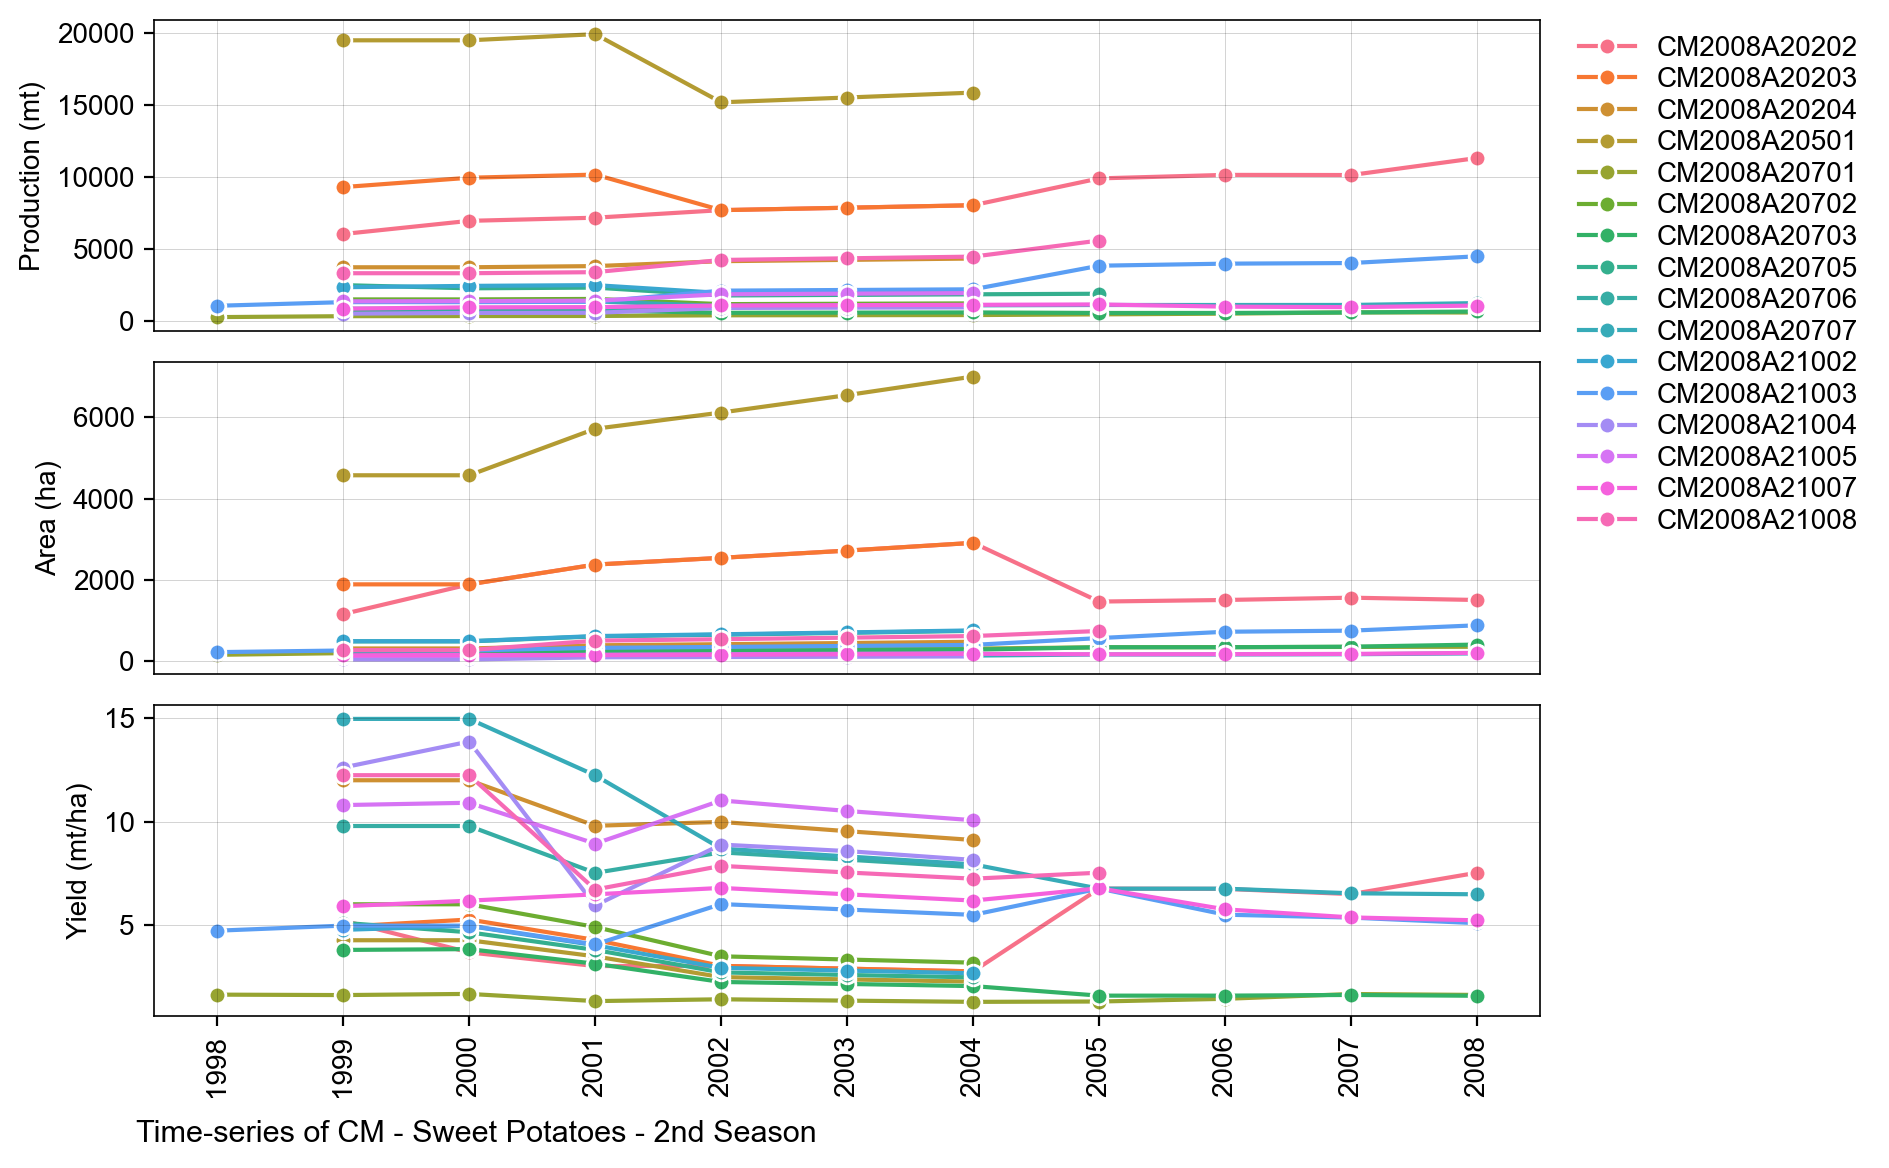

In [8]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'CM', 'Cameroon'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava', 'Annual'],
    ['Maize', 'North 1st Season'],
    ['Millet', 'North 2nd Season'],
    ['Maize', '1st Season'],
    ['Sweet Potatoes', '2nd Season']
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)